# Simulating Clifford randomized benchmarking using implicit models

This tutorial demonstrates shows how to simulate Clifford RB sequences using $n$-qubit "implicit" models which build $n$-qubit process matrices from smaller building blocks.  This restricts the noise allowed in the $n$-qubit model; in this tutorial we take $n=3$ and use a `LocalNoiseModel`.

In [1]:
import pygsti
import numpy as np

## Get some CRB circuits

First, we follow the [Clifford RB](../CliffordRB.ipynb) tutorial to generate a set of sequences.  If you want to perform Direct RB instead, just replace this cell with the contents of the [Direct RB](../DirectRB.ipynb) tutorial up until the point where it creates `circuitlist`:

In [2]:
#Specify the device to be benchmarked - in this case 2 qubits
nQubits = 3
qubit_labels = list(range(nQubits)) 
gate_names = ['Gxpi2', 'Gypi2','Gcphase'] 
availability = {'Gcphase':[(i,i+1) for i in range(nQubits-1)]}
pspec = pygsti.obj.ProcessorSpec(nQubits, gate_names, availability=availability, 
                                 qubit_labels=qubit_labels)

#Specify RB parameters (k = number of repetitions at each length)
lengths = [0,1,2,4,8,16]
k = 10
subsetQs = qubit_labels
randomizeout = False # ==> all circuits have the *same* ideal outcome (the all-zeros bitstring)

#Generate clifford RB circuits
exp_design = pygsti.protocols.CliffordRBDesign(pspec, lengths, k, qubit_labels=subsetQs, randomizeout=randomizeout)

#Collect all the circuits into one list:
circuitlist = exp_design.all_circuits_needing_data

- Sampling 10 circuits at CRB length 0 (1 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 1 (2 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 2 (3 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 4 (4 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 8 (5 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 16 (6 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,


## Create a model to simulate these circuits
Now we need to create a model that can simulate circuits like this. The RB circuits use pyGSTi's "multi-qubit" conventions, which mean:
1. RB circuits use our "multi-qubit" gate naming, so you have gates like `Gxpi2:0` and `Gcphase:0:1`.
2. RB circuits do gates in parallel (this only matters for >1 qubits), so you have layers like `[Gypi2:0Gypi2:1]`

"Implicit" models in pyGSTi (see the [implicit model tutorial](../../objects/ImplicitModel.ipynb)) are designed to efficiently describe multi-qubit processors.  There are numerous ways of constructing implicit models, all of which can simulate the type of circuits described above.  Here we'll demonstrate the simplest type: a "local noise model" (class `LocalNoiseModel`) where the noise on a gate can only act on that gate's target qubits - so, for instance, 1-qubit gates are still given by 1-qubit operators, not $n$-qubit ones.

The construction of a local noise model follows the same pattern as building the `ProcessorSpec` above (in fact, `pspec.models['target']` *is* essentially the same model we build below except it was built with the default `parmeterization="static"` argument.

In [3]:
myModel = pygsti.obj.LocalNoiseModel.build_from_parameterization(nQubits, gate_names,
                                                                 availability=availability, 
                                                                 qubit_labels=qubit_labels,
                                                                 parameterization="full")

Setting `parameterization="full"` is important, as it lets us assign arbitrary numpy arrays to gates as we'll show below.  If you need to use other gates that aren't built into pyGSTi, you can use the `nonstd_gate_unitaries`
argument of `build_from_parameterization` (see the docstring).

The `build_from_parameterization` function creates a model with ideal (perfect) gates.  We'll now create a 1-qubit depolarization superoperator, and a corresponding 2-qubit one (just the tensor product of two 1-qubit ones) to add some simple noise.  

In [4]:
depol1Q = np.array([[1, 0,   0, 0],
                    [0, 0.99, 0, 0],
                    [0, 0, 0.99, 0],
                    [0, 0, 0, 0.99]], 'd') # 1-qubit depolarizing operator
depol2Q = np.kron(depol1Q,depol1Q)

As detailed in the [implicit model tutorial](../../objects/ImplicitModel.ipynb), the gate operations of a `LocalNoiseModel` are held in its `.operation_blks['gates']` dictionary.  We'll alter these by assigning new process matrices to each gate.  In this case, it will be just a depolarized version of the original gate.

In [5]:
myModel.operation_blks['gates']["Gxpi2"] = np.dot(depol1Q, myModel.operation_blks['gates']["Gxpi2"])
myModel.operation_blks['gates']["Gypi2"] = np.dot(depol1Q, myModel.operation_blks['gates']["Gypi2"])  
myModel.operation_blks['gates']["Gcphase"] = np.dot(depol2Q, myModel.operation_blks['gates']["Gcphase"])

Here's what the gates look like now:

In [6]:
print(myModel.operation_blks['gates']["Gxpi2"])
print(myModel.operation_blks['gates']["Gypi2"])
print(myModel.operation_blks['gates']["Gcphase"])

FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.99   0   0
   0   0   0-0.99
   0   0 0.99   0

FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0   0   0 0.99
   0   0 0.99   0
   0-0.99   0   0

FullDenseOp with shape (16, 16)
 1.00   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 0.99   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 0.99   0
   0   0   0 0.99   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 0.99   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 0.98   0   0   0   0   0
   0   0   0   0   0   0   0   0   0-0.98   0   0   0   0   0   0
   0   0   0   0 0.98   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 0.99   0   0   0   0
   0   0   0   0   0   0-0.98   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 0.98   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 0.9

Now that our `Model` object is set to go, generating simulated data is easy:

In [7]:
ds = pygsti.construction.generate_fake_data(myModel, circuitlist, 100, seed=1234)

## Running RB on the simulated `DataSet`
To run an RB analysis, we just package up the experiment design and data set into a `ProtocolData` object and give this to a `RB` protocol's `run` method.  This returns a `RandomizedBenchmarkingResults` object that can be used to plot the RB decay curve.  (See the [RB analysis tutorial](../RBAnalysis.ipynb) for more details.)

In [8]:
data = pygsti.protocols.ProtocolData(exp_design, ds)
results = pygsti.protocols.RB().run(data)

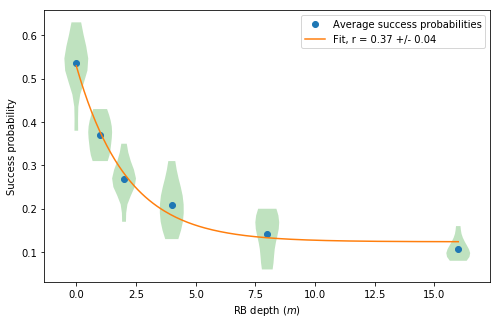

In [9]:
%matplotlib inline
results.plot()